<a href="https://colab.research.google.com/github/yonilev2003/Predicting-Real-Estate-Prices-In-NY-State-Using-ML/blob/main/Predicting_Real_Estate_Prices_In_NY_State_Using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Real estate in the US appriciate on average 5.4% a year, and a bit higher in the state of New York. This figure makes real estate a solid investment for the rich and a headache for house-seekers. This project is based on a 1.4 million houses dataset across America, about 600,000 of them in the state of New York..

# Imports & Installations

In [1]:
# Install the Kaggle API and pandas_profiling
!pip install kaggle

In [33]:
# Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [3]:
# Setting Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'yonathanlevy'
os.environ['KAGGLE_KEY'] = 'd161e19bbcf37f55b9e5a0d6e5497e55'

In [4]:
# Download the dataset directly from Kaggle
!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset -p /content

# Unzip the dataset
!unzip /content/usa-real-estate-dataset.zip -d /content/houses

usa-real-estate-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/usa-real-estate-dataset.zip
replace /content/houses/realtor-data.zip.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# Specifying the file path
file_path = '/content/houses/realtor-data.zip.csv'

# Loading the CSV file into a DataFrame
houses = pd.read_csv(file_path)

# Looking at the first 5 rows of the DataFrame
print(houses.head())

     status  bed  bath  acre_lot        city        state  zip_code  \
0  for_sale  3.0   2.0      0.12    Adjuntas  Puerto Rico     601.0   
1  for_sale  4.0   2.0      0.08    Adjuntas  Puerto Rico     601.0   
2  for_sale  2.0   1.0      0.15  Juana Diaz  Puerto Rico     795.0   
3  for_sale  4.0   2.0      0.10       Ponce  Puerto Rico     731.0   
4  for_sale  6.0   2.0      0.05    Mayaguez  Puerto Rico     680.0   

   house_size prev_sold_date     price  
0       920.0            NaN  105000.0  
1      1527.0            NaN   80000.0  
2       748.0            NaN   67000.0  
3      1800.0            NaN  145000.0  
4         NaN            NaN   65000.0  


In [6]:
# Separating the houses in the state of 'New York', dropping all other homes and than dropping the 'state' column
houses = houses[houses['state'] == 'New York']
houses.drop(columns=['state'], inplace=True)

In [7]:
# Descriptive statistics
houses.describe()

,bed,bath,acre_lot,zip_code,house_size,price
count,548869.000000,571598.000000,443675.000000,652789.000000,444762.000000,6.530240e+05
mean,3.292634,2.374438,52.264063,11652.482684,2096.308248,1.005258e+06
std,2.136848,1.736455,1564.263409,1419.369449,3697.379077,3.715096e+06
min,1.000000,1.000000,0.000000,4715.000000,4.000000,0.000000e+00
25%,2.000000,1.000000,0.100000,10701.000000,1114.000000,2.300000e+05
50%,3.000000,2.000000,0.280000,11428.000000,1672.000000,4.990000e+05
75%,4.000000,3.000000,1.400000,12494.000000,2430.000000,9.250000e+05
max,123.000000,123.000000,100000.000000,99999.000000,352836.000000,8.750000e+08


In [8]:
# Dataset information
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653061 entries, 30149 to 1401065
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          653061 non-null  object 
 1   bed             548869 non-null  float64
 2   bath            571598 non-null  float64
 3   acre_lot        443675 non-null  float64
 4   city            652952 non-null  object 
 5   zip_code        652789 non-null  float64
 6   house_size      444762 non-null  float64
 7   prev_sold_date  355236 non-null  object 
 8   price           653024 non-null  float64
dtypes: float64(6), object(3)
memory usage: 49.8+ MB


In [9]:
# Making a table including how many unique, missing and duplicated values by column
# Creating a DataFrame to store the information
data_summary = pd.DataFrame(index=houses.columns, columns=['Unique Values', 'Missing Values', 'Duplicated Values'])

# Filling in the information
for column in houses.columns:
    data_summary.loc[column, 'Unique Values'] = houses[column].nunique()
    data_summary.loc[column, 'Missing Values'] = houses[column].isnull().sum()
    data_summary.loc[column, 'Duplicated Values'] = houses[column].duplicated().sum()

# Display the summary table
data_summary

,Unique Values,Missing Values,Duplicated Values
status,2,0,653059
bed,40,104192,653020
bath,35,81463,653025
acre_lot,3116,209386,649944
city,1609,109,651451
zip_code,1523,272,651537
house_size,5066,208299,647994
prev_sold_date,8366,297825,644694
price,5600,37,647460


The columns:
* status = the property sale status (either for sale or ready to build).
* bed = no. of bedrooms.
* bath = no. of bathrooms.
* acre_lot = total land/lot size in acres.
* city
* state
* zip_code
* house_size
* prev_sold_date = the last selling date
* price

# Cleaning

First, only 147 of the houses have a status that is not 'for_sale'. I dropped those rows that have the status 'ready_to_build' and dropped the column.

Then, I checked and found that 45 houses have a price of 0$ and 126 houses have reported a lot size of 0, so I dropped them.

Before handling missing values, I wanted to understand the numerical distributions. Visualizing a data of so many houses is computationally expensive, so I used stratified sampling with the same variance. My stratifier is the target variable 'price'. The below visualizations are 5% of the data each.

Looking at the visualization, it seems like there are many outliers. For example: some houses have dozens of bedrooms and batrooms, and some have a huge plot size. Therefore, it's neccessary to impute using the median. Below the visualizations I outputed a table of all the percentile values in jumps of 5 (5th percentile, 10th percentile... up until the 95th).

Regarding missing values, I imputed the median in 'bed', 'bath', 'acre_lot' and 'house_size'. Because imputing is irrelevant to try and understand the previous selling date (and because there are more than 10k unique values), I decided to drop this column altogether. Also, I dropped rows with missing 'city', 'zip_code' and 'price'.

Afterwards, I checked for outliers using three metrices:
1. Checking how many values are below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
2. Checking the 90th, 99th, and 99.9th percentiles for each numerical column.
3. Printing out the numerical percentiles of the 5th, 10th, 15th percentiles and so on up to 95th percentile.

I decided to cap and floor the 5th and 95th percentiles. The outliers held in the top 5% values of each numerical column are the reason for the extrem right-skewness. I conflicted myself whether I should log-transform as well, but decided not to because the data would be less Interpretable.

Last but not least, I removed duplicates. Apparently, the dataset holds many duplicated data, so I removed it completely and left with only about 10% of the original dataset.

In [10]:
# House status
houses['status'].value_counts()

for_sale          652914
ready_to_build       147
Name: status, dtype: int64

In [11]:
# Dropping rows where the value of 'status' column is 'ready_to_build'
houses = houses[houses['status'] != 'ready_to_build']

# Checking it worked
houses['status'].value_counts()

for_sale    652914
Name: status, dtype: int64

In [12]:
# Dropping the column because of a lost-relevance
houses.drop(columns=['status'], inplace=True)

In [13]:
# Checking houses with no price
zero_price = (houses['price'] == 0).sum()
zero_price

45

In [14]:
# Dropping houses with no prices
houses = houses[houses['price'] != 0]

In [15]:
# Checking houses with no land size
no_acre_lot_count = (houses['acre_lot'] == 0).sum()
no_acre_lot_count

126

In [16]:
# Dropping houses with no land size
houses = houses[houses['acre_lot'] != 0]

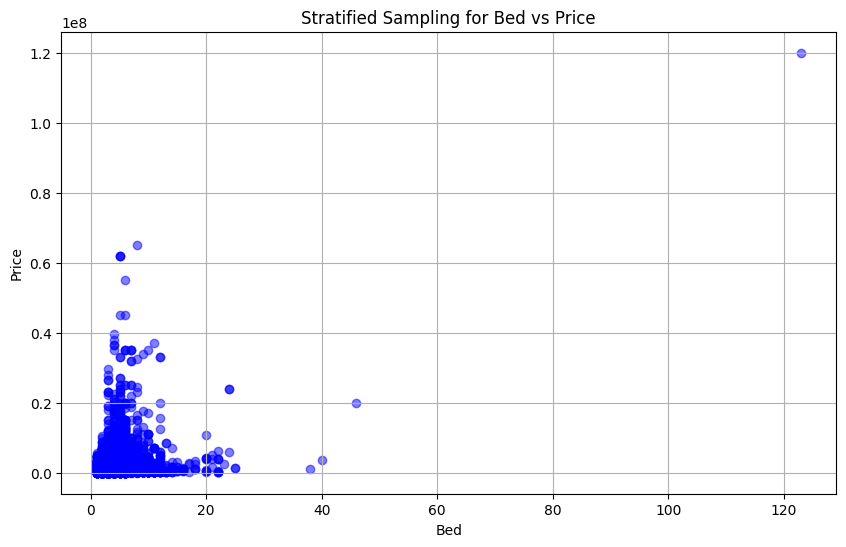

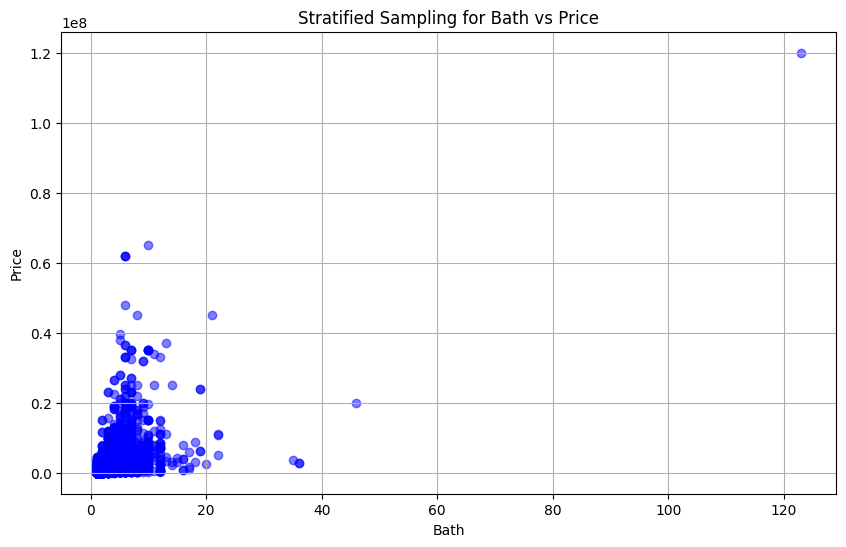

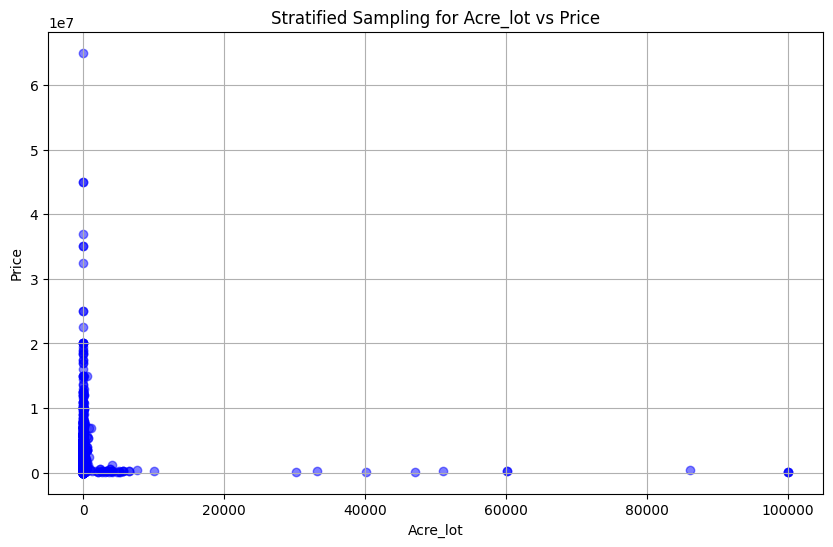

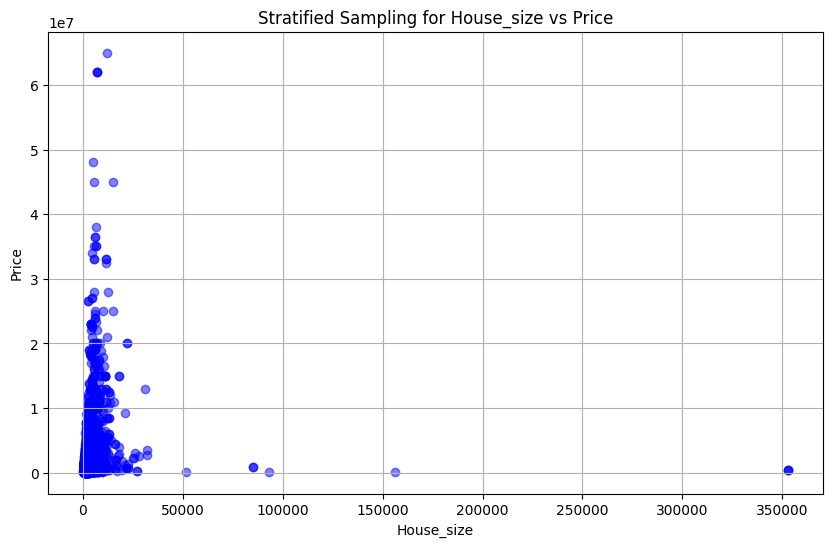

In [17]:
# Visualizing a stratified sample of the data
# Defining the numerical columns
numerical_columns = ['bed', 'bath', 'acre_lot', 'house_size', 'price']

# Defining the column for stratification
stratify_column = 'price'

# Defining the sample size as 5% of the data
sample_size = int(0.05 * len(houses))

# Performing stratified sampling and visualizing for each numerical column
for column in numerical_columns[:-1]:
    strata, _ = pd.qcut(houses[stratify_column], q=sample_size, retbins=True, duplicates='drop')
    stratified_sample = houses.groupby(strata, group_keys=False).apply(lambda x: x.sample(int(len(x)*(sample_size/len(houses)))))

    plt.figure(figsize=(10, 6))
    plt.scatter(stratified_sample[column], stratified_sample['price'], alpha=0.5, color='b')
    plt.xlabel(column.capitalize())  # Capitalize the column name for labeling
    plt.ylabel('Price')
    plt.title(f'Stratified Sampling for {column.capitalize()} vs Price')
    plt.grid(True)
    plt.show()

In [18]:
# Missing values
# Imputing median for 'bed', 'bath', 'acre_lot', and 'house_size'
for column in ['bed', 'bath', 'acre_lot', 'house_size']:
    median_value = houses[column].median()
    houses[column].fillna(median_value, inplace=True)

# Dropping 'previous_selling_date' column
houses.drop(columns=['prev_sold_date'], inplace=True)

# Dropping rows with missing values in 'city', 'zip_code', and 'price'
houses.dropna(subset=['city', 'zip_code', 'price'], inplace=True)

In [19]:
# Printing out a table of the values percentiles
# Define percentiles
percentiles = [i/100 for i in range(5, 96, 5)]

# Calculate percentiles for each numerical column
percentile_table = pd.DataFrame(index=percentiles)
for col in numerical_columns:
    percentile_table[col] = houses[col].quantile(percentiles)

# Display the percentile table
percentile_table

,bed,bath,acre_lot,house_size,price
0.05,1.0,1.0,0.05,729.0,65000.0
0.10,1.0,1.0,0.06,900.0,115000.0
0.15,2.0,1.0,0.09,1055.0,152000.0
0.20,2.0,1.0,0.12,1200.0,189900.0
0.25,2.0,1.0,0.16,1364.0,230000.0
0.30,3.0,2.0,0.22,1525.0,275000.0
0.35,3.0,2.0,0.28,1672.0,325000.0
0.40,3.0,2.0,0.28,1672.0,375900.0
0.45,3.0,2.0,0.28,1672.0,436800.0
0.50,3.0,2.0,0.28,1672.0,499000.0


In [20]:
# Calculating outliers using 2 methods
# Method 1 - using IQR
# Method 2 - sing percentiles (90th, 99th and 99.9th)
for column in numerical_columns:
    q1 = houses[column].quantile(0.25)
    q3 = houses[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound_iqr = q1 - 1.5 * iqr
    upper_bound_iqr = q3 + 1.5 * iqr
    outliers_iqr = ((houses[column] < lower_bound_iqr) | (houses[column] > upper_bound_iqr)).sum()

    percentile_99 = houses[column].quantile(0.99)
    percentile_999 = houses[column].quantile(0.999)
    outliers_percentiles = ((houses[column] > percentile_99) | (houses[column] > percentile_999)).sum()

    print(f"Outliers count for {column}:")
    print(f"  Using IQR method: {outliers_iqr}")
    print(f"  Using percentiles (99th, 99.9th): ", percentile_99, percentile_999)
    print()

Outliers count for bed:
  Using IQR method: 16636
  Using percentiles (99th, 99.9th):  10.0 20.0

Outliers count for bath:
  Using IQR method: 11675
  Using percentiles (99th, 99.9th):  8.0 16.0

Outliers count for acre_lot:
  Using IQR method: 119247
  Using percentiles (99th, 99.9th):  103.0 3739.0

Outliers count for house_size:
  Using IQR method: 69183
  Using percentiles (99th, 99.9th):  7561.0 19750.0

Outliers count for price:
  Using IQR method: 62875
  Using percentiles (99th, 99.9th):  9650000.0 33000000.0



In [21]:
# Handling the outliers by capping the 95th percentile and flooring the 5th percentile
# Defining the numerical columns
numerical_columns = ['bed', 'bath', 'acre_lot', 'house_size', 'price']

# Calculating the 5th and 95th percentiles for each numerical column
percentiles_5 = houses[numerical_columns].quantile(0.05)
percentiles_95 = houses[numerical_columns].quantile(0.95)

# Defining the upper and lower limits for capping and flooring
upper_limits = percentiles_95
lower_limits = percentiles_5

# Capping and flooring values in numerical columns
for col in numerical_columns:
    houses[col] = houses[col].apply(lambda x: min(upper_limits[col], max(lower_limits[col], x)))

# The new descriptive statistics
houses.describe()

,bed,bath,acre_lot,zip_code,house_size,price
count,652412.000000,652412.000000,652412.000000,652412.000000,652412.000000,6.524120e+05
mean,3.118592,2.235111,1.516393,11652.496491,1820.752857,7.711933e+05
std,1.342227,1.101521,3.444349,1419.469127,801.941016,8.027701e+05
min,1.000000,1.000000,0.050000,4715.000000,729.000000,6.500000e+04
25%,2.000000,1.000000,0.160000,10701.000000,1364.000000,2.300000e+05
50%,3.000000,2.000000,0.280000,11428.000000,1672.000000,4.990000e+05
75%,4.000000,3.000000,0.560000,12495.000000,2016.000000,9.250000e+05
max,6.000000,5.000000,14.280000,99999.000000,4000.000000,3.200000e+06


In [22]:
# Removing duplicates
houses = houses.drop_duplicates()
houses.shape

(65279, 7)

# Preparing for ML

Starting out with the correlation matrix - there is strong correlation between the number of baths and the target variable 'price'. There's also a certain correlation with the size of the hosue and size, and between the number of beds and the price. However, the 'zip code' column give a negative correlation.

However, zip code isn't ordinal or truly nominal. That's why I binned zip codes into 10 groups by price using the following formula: 50% of the price / house_size + 50% of the price / acre_lot (land size).

It is well know what where you live accounts for your life opportunities. Besides, some zip codes in America, and certainley in the state of New York are much more expensive and in-demand than others.

Later, I dropped 'city' because I already have a zip code. **All that people need to do is to answer the question - from 1 to 10, how attractive is your zip code?**

Lastly, because of no correlation, I dropped 'acre_lot' to exclude this column in the modeling.

<ipython-input-23-c1a1565790d2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = houses.corr()


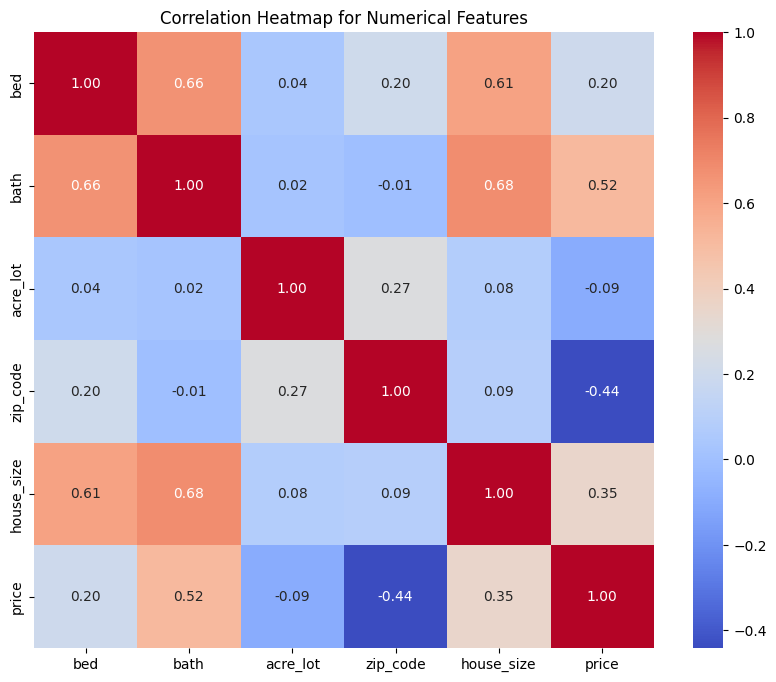

In [23]:
# Correlation matrix for the numerical columns
correlation_matrix = houses.corr()

# Plotting the correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap for Numerical Features")
plt.show()

In [24]:
# Creating the 'zc_attractiveness' column
houses['zc_attractiveness'] = (0.5 * houses['price'] / houses['house_size']) + (0.5 * houses['price'] / houses['acre_lot'])

In [25]:
# Ranking these averages into 10 groups using qcut for quantile-based discretization
houses['zc_attractiveness'] = pd.qcut(houses['zc_attractiveness'], q=10, labels=False) + 1

In [26]:
# Making sure it worked
houses['zc_attractiveness'].head()

30149    1
54248    2
54258    4
54259    2
54262    2
Name: zc_attractiveness, dtype: int64

<ipython-input-27-c1a1565790d2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = houses.corr()


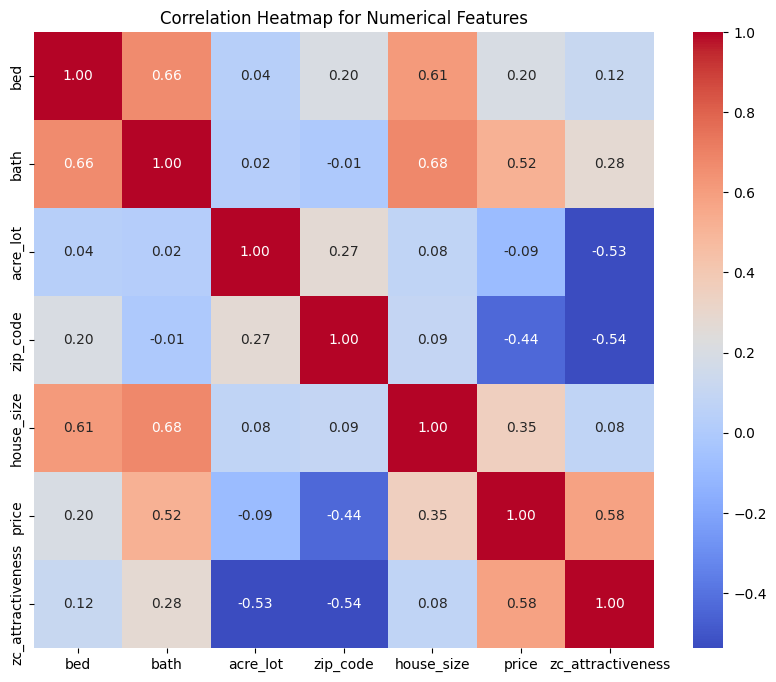

In [27]:
# Correlation matrix for the numerical columns
correlation_matrix = houses.corr()

# Plotting the correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap for Numerical Features")
plt.show()

In [28]:
# Dropping the 'zip_code' and 'city' columns
houses.drop(columns=['zip_code', 'city', 'acre_lot'], inplace=True)

In [29]:
# Split data into features and target variable
X = houses.drop(columns=['price'])  # Features
y = houses['price']  # Target variable

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training set into train and validation sets (70% train, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


# ML

In [30]:
# Models
models = [
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor()
]

In [34]:
# Training and evaluation
for model in models:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    print(f"Model: {model.__class__.__name__}")
    print(f"Training MSE: {mse_train}")
    print(f"Validation MSE: {mse_val}")
    print(f"Training R2 Score: {r2_train}")
    print(f"Validation R2 Score: {r2_val}")
    print("="*30)

Model: RandomForestRegressor
Training MSE: 142951124093.8586
Validation MSE: 261112010270.17783
Training R2 Score: 0.7950421816824438
Validation R2 Score: 0.6294143544345668
Model: GradientBoostingRegressor
Training MSE: 245404449151.79486
Validation MSE: 247572398867.58517
Training R2 Score: 0.6481485485168396
Validation R2 Score: 0.648630573662258
Model: SVR
Training MSE: 777338081097.503
Validation MSE: 786662216527.4276
Training R2 Score: -0.11451741430373619
Validation R2 Score: -0.11647765666582632
Model: KNeighborsRegressor
Training MSE: 255189758492.61392
Validation MSE: 325372967910.53235
Training R2 Score: 0.6341187487040039
Validation R2 Score: 0.5382113935015836
Model: MLPRegressor
Training MSE: 588815325325.6466
Validation MSE: 592290523844.586
Training R2 Score: 0.15577925507287893
Validation R2 Score: 0.15938617333565275


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create a base RandomForestRegressor model
base_model = RandomForestRegressor(random_state=42)

# Instantiate the grid search with the base model and parameter grid
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the best model on training and validation data
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

# Print evaluation metrics
print("Model: RandomForestRegressor after Hyperparameter Tuning")
print(f"Training MSE: {mse_train}")
print(f"Validation MSE: {mse_val}")
print(f"Training R2 Score: {r2_train}")
print(f"Validation R2 Score: {r2_val}")

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
Model: RandomForestRegressor after Hyperparameter Tuning
Training MSE: 217492163258.52362
Validation MSE: 231907835672.45267
Training R2 Score: 0.6881681094486206
Validation R2 Score: 0.6708626504562825
